# Импортирование библиотек

In [61]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy import stats
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer



from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD


import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

## Подготовка данных

Подгружаем dataset

In [ ]:
from google.colab import drive; drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_emotion = '/content/drive/MyDrive/combined_emotion.csv'

In [ ]:
df_emotion = pd.read_csv(path_emotion)

In [ ]:
df_emotion.head(10)

,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear
5,i was beginning to feel quite disheartened,sad
6,i would think that whomever would be lucky eno...,love
7,i fear that they won t ever feel that deliciou...,joy
8,im forever taking some time out to have a lie ...,suprise
9,i can still lose the weight without feeling de...,sad


In [ ]:
df_emotion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422746 entries, 0 to 422745
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  422746 non-null  object
 1   emotion   422746 non-null  object
dtypes: object(2)
memory usage: 6.5+ MB


In [ ]:
df_emotion.shape

(422746, 2)

# EDA

In [ ]:
df_emotion.isnull().sum()

,0
sentence,0
emotion,0


Посмотрим статистики по таблице

In [ ]:
df_emotion.describe()

,sentence,emotion
count,422746,422746
unique,393822,6
top,i feel more adventurous willing to take risks,joy
freq,16,143067


Можно заметить, что есть повторяющие sentence. Давайте проверим на наличие дублей таблицу, и если есть, то удалим повторяющиеся строки

In [ ]:
duplicate_rows = df_emotion[df_emotion.duplicated()]
print("Кол-во дублирующий строк: ", duplicate_rows.shape[0])

Кол-во дублирующий строк:  6623


In [ ]:
df_emotion.drop(duplicate_rows.index, inplace=True)

Посмотрим ближе на целевую переменную

Text(0, 0.5, 'Кол-во')

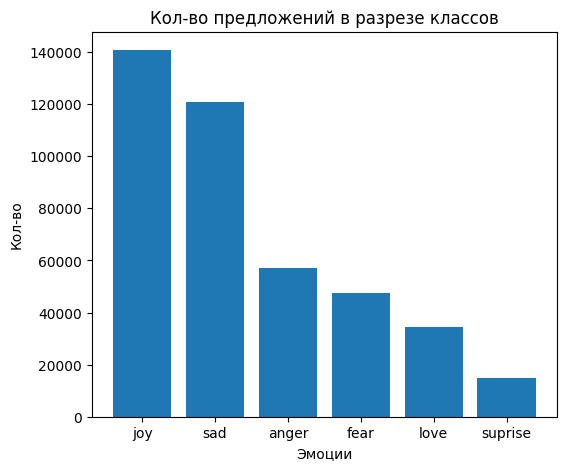

In [ ]:
emotion_counts = df_emotion['emotion'].value_counts()

plt.figure(figsize=(6, 5))
plt.bar(emotion_counts.index, emotion_counts.values)
plt.title('Кол-во предложений в разрезе классов')
plt.xlabel('Эмоции')
plt.ylabel('Кол-во')

Можно заметить дисбаланс классов. Чтобы это не сказалось на обучении и метриках качества, добавим веса для классов в будущую модель

Посчитаем длину предложения и посмотрим распределение для каждого класса

In [ ]:
def length(text):
    '''a function which returns the length of text'''
    return len(text)

In [ ]:
df_emotion['length'] = df_emotion['sentence'].apply(length)

Text(0, 0.5, 'кол-во предложений')

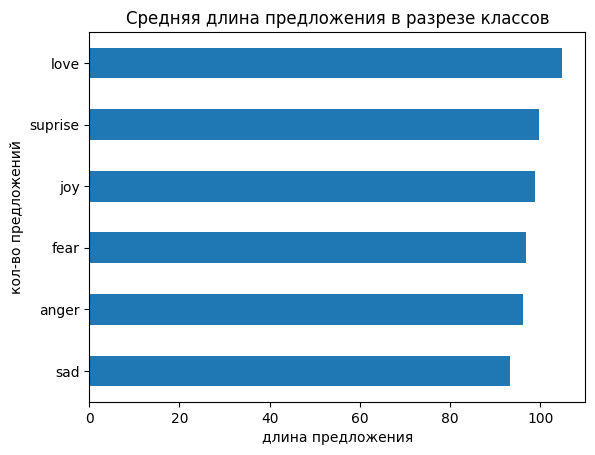

In [ ]:
df_emotion.groupby('emotion')['length'].mean().sort_values().plot(kind="barh")
plt.title('Средняя длина предложения в разрезе классов')
plt.xlabel('длина предложения')
plt.ylabel('кол-во предложений')

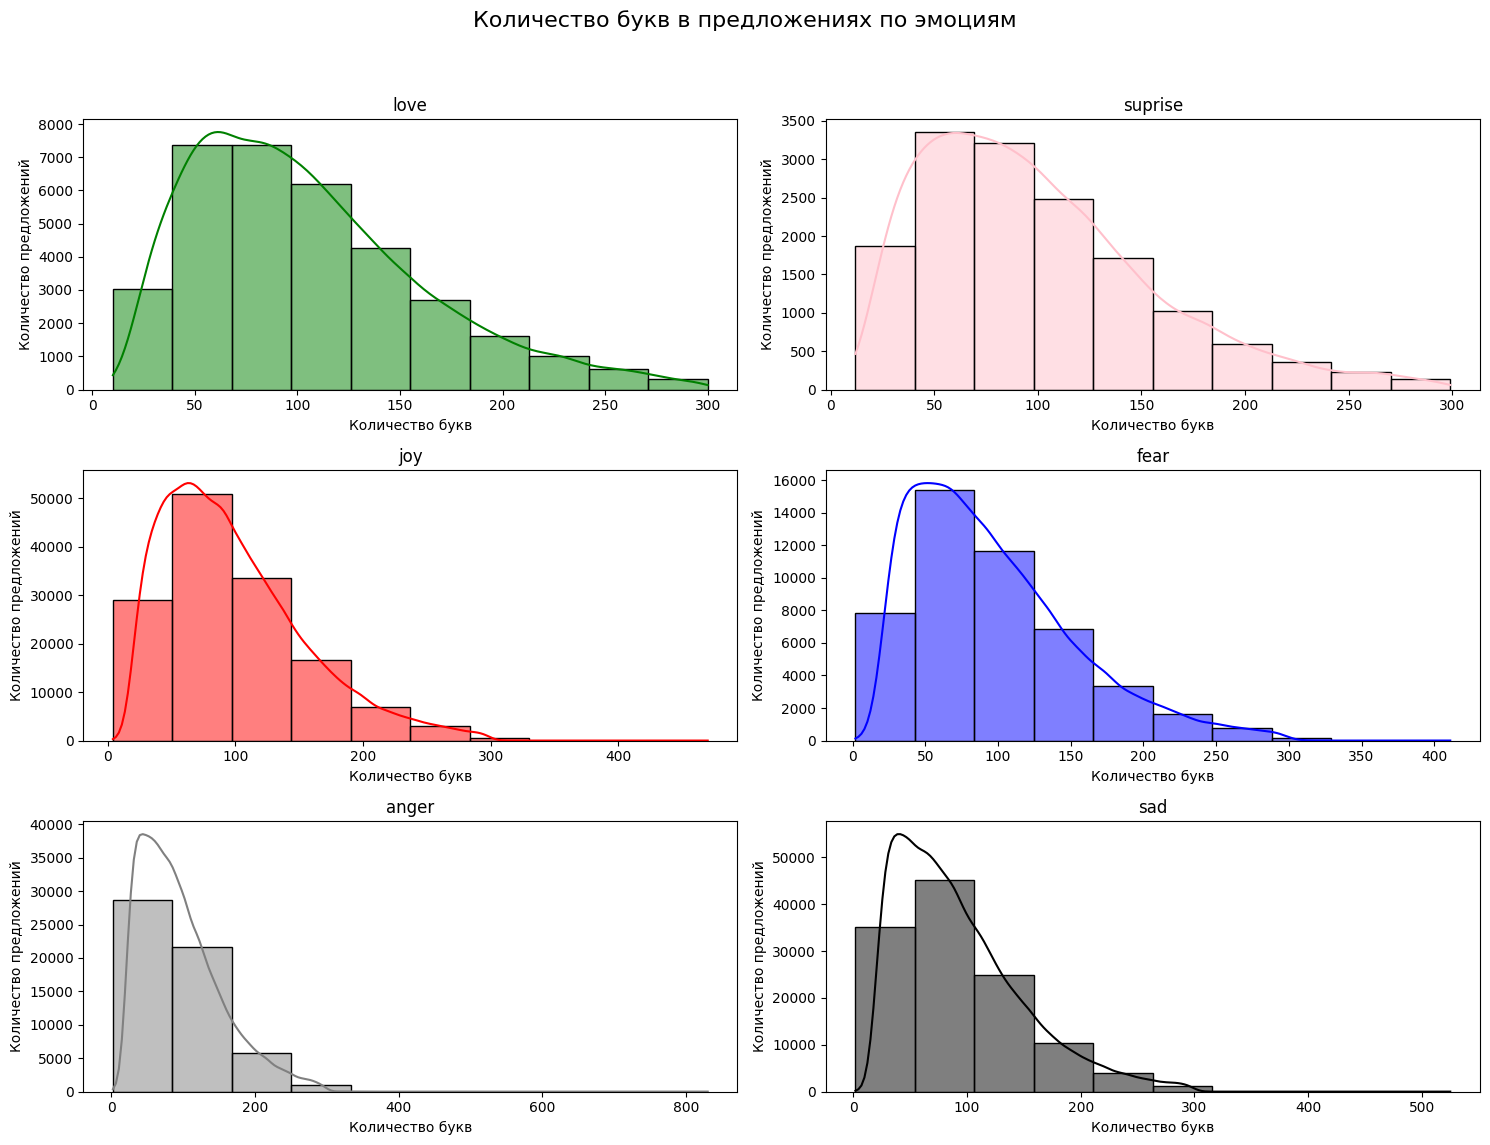

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

emotions = ['love', 'suprise', 'joy', 'fear', 'anger', 'sad']
colors = ['green', 'pink', 'red', 'blue', 'grey', 'black']

for i, emotion in enumerate(emotions):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    sentence_len = df_emotion[df_emotion['emotion'] == emotion]['sentence'].str.len()
    sns.histplot(sentence_len, ax=ax, color=colors[i], bins=10, kde=True)
    ax.set_title(emotion)
    ax.set_xlabel('Количество букв')
    ax.set_ylabel('Количество предложений')


fig.suptitle('Количество букв в предложениях по эмоциям', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


plt.show()

Длина предложений в целом по всем классам не превышает 400 символов, а также длина, как правило, находится в диапозоне от 50 до 200 сичмволов

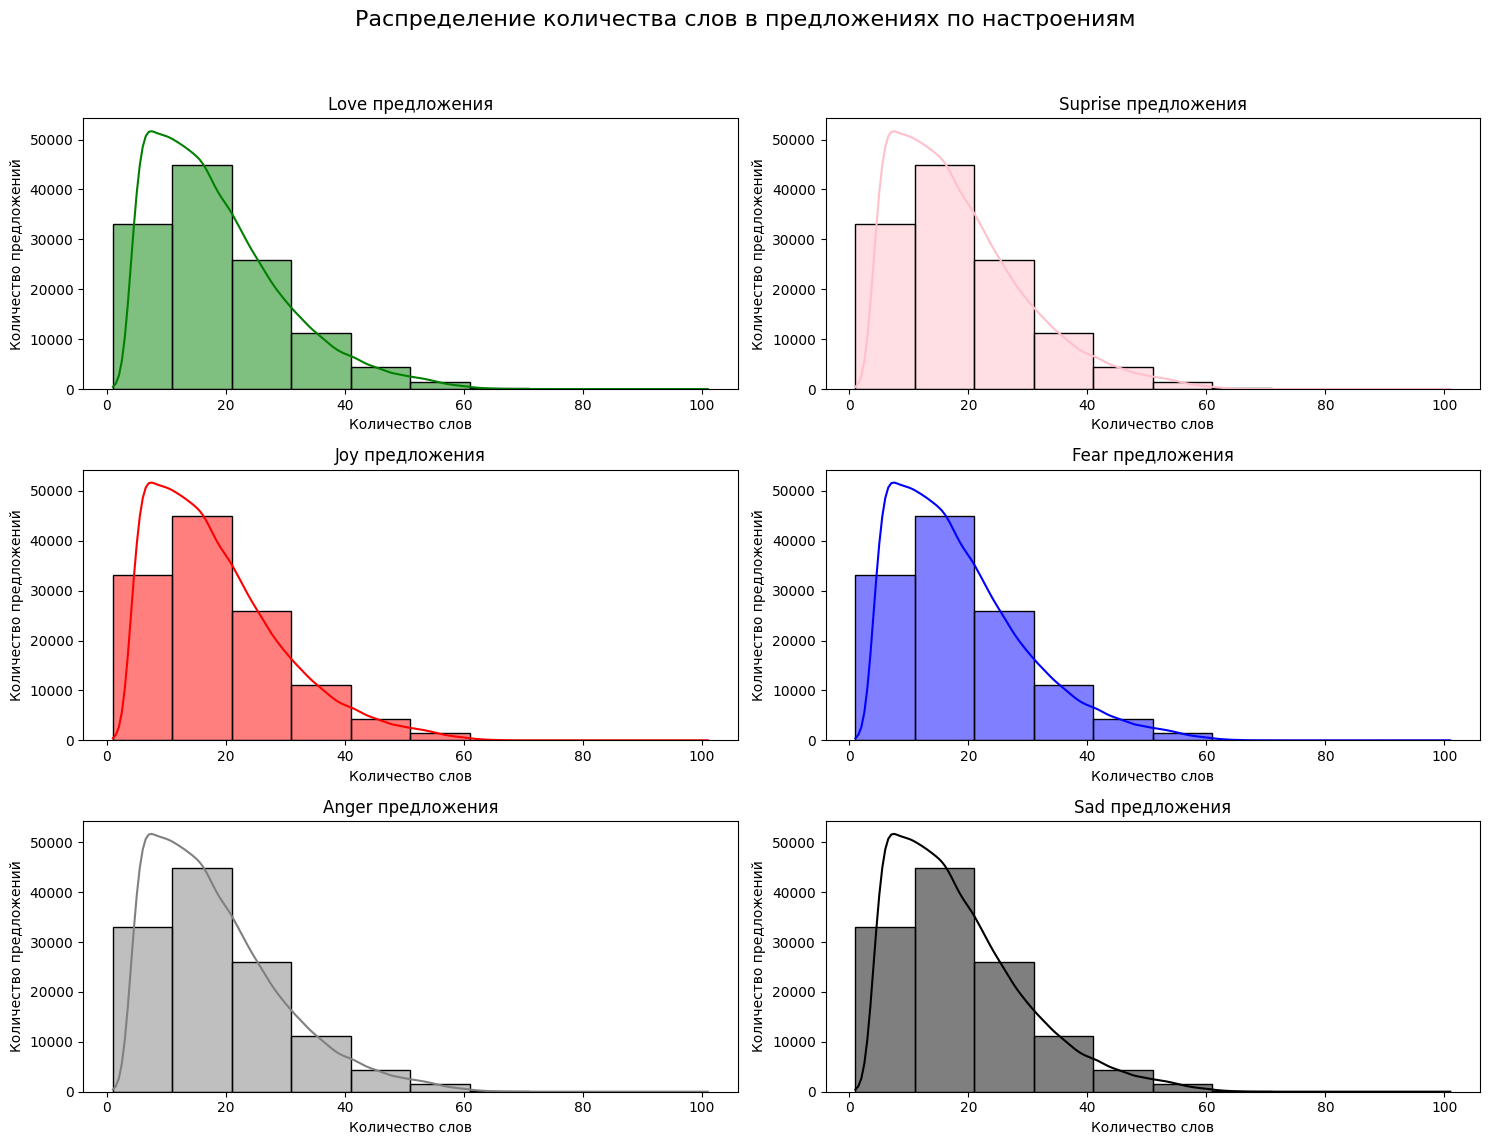

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))  # 3 строки, 2 столбца

for i, sentiment in enumerate(emotions):
    row = i // 2  # Номер строки
    col = i % 2   # Номер столбца
    ax = axes[row, col]  # Текущий подграфик


    sentence_len = df_emotion[df_emotion['emotion'] == emotion]['sentence'].str.split().map(lambda x: len(x))

    # Строим гистограмму
    sns.histplot(sentence_len, ax=ax, color=colors[i], bins=10, kde=True)

    ax.set_title(f'{sentiment.capitalize()} предложения')
    ax.set_xlabel('Количество слов')
    ax.set_ylabel('Количество предложений')

fig.suptitle('Распределение количества слов в предложениях по настроениям', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

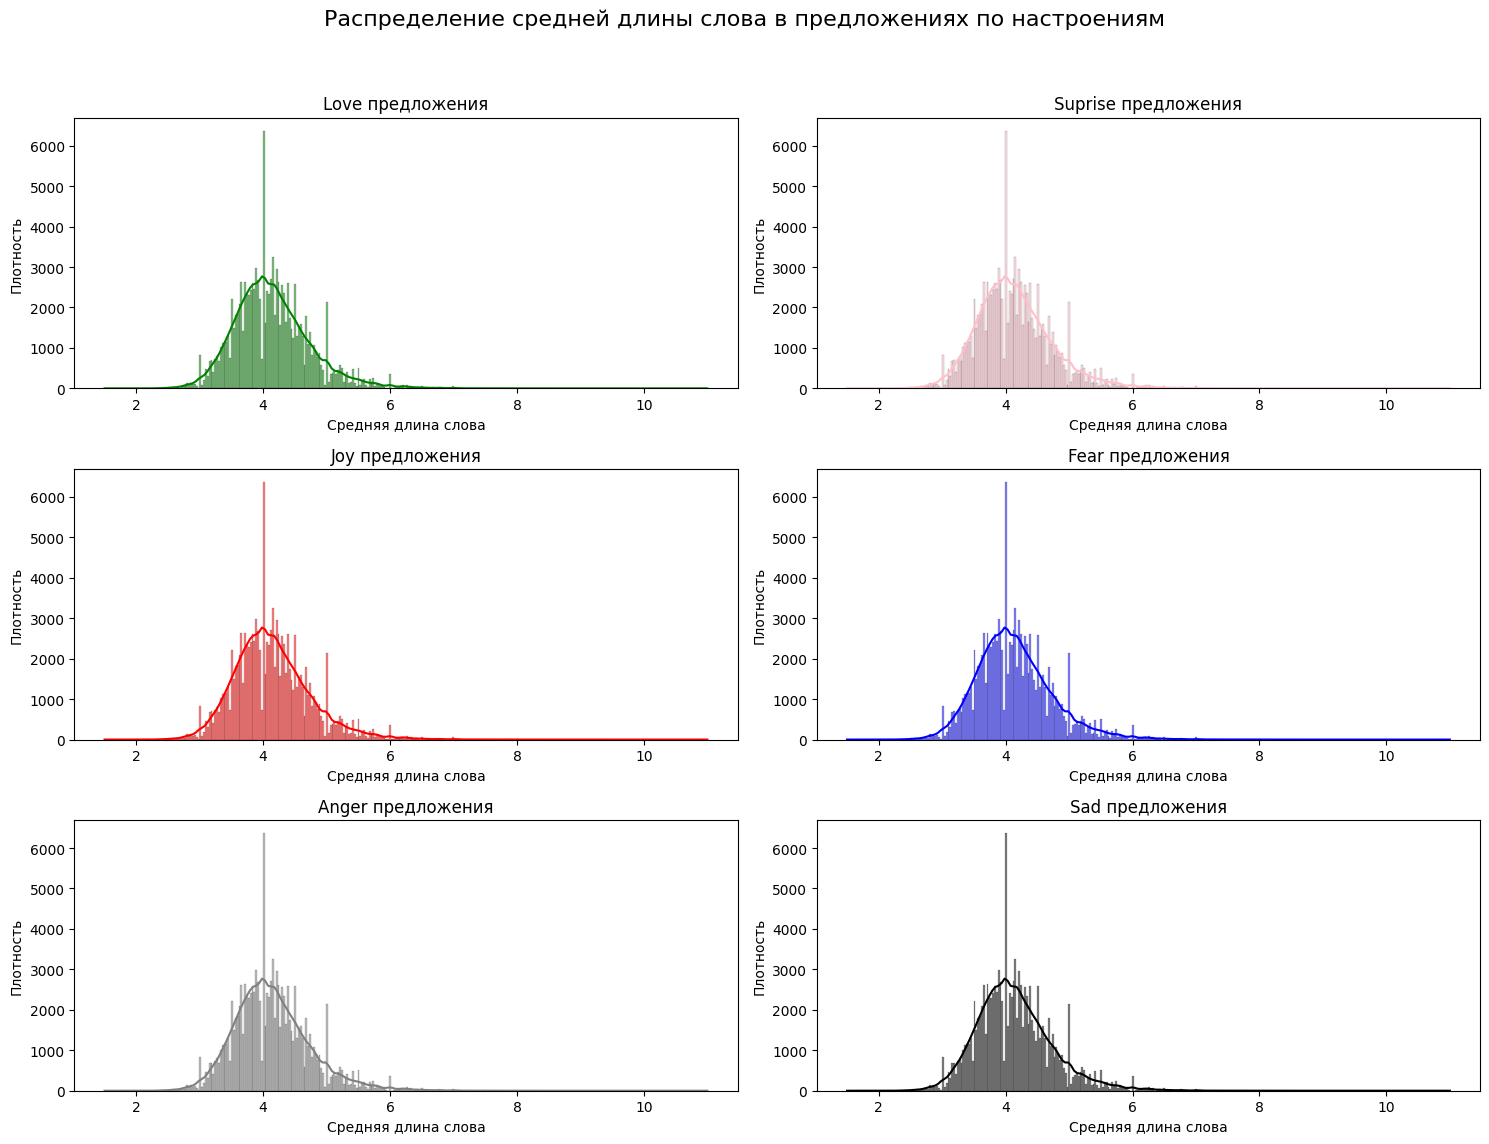

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

for i, sentiment in enumerate(emotions):
    row = i // 2
    col = i % 2
    ax = axes[row, col]


    word_lengths = df_emotion[df_emotion['emotion'] == emotion]['sentence'].str.split().apply(lambda x: [len(i) for i in x])
    mean_word_length = word_lengths.map(lambda x: np.mean(x))

    sns.histplot(mean_word_length, ax=ax, color=colors[i], kde=True)

    ax.set_title(f'{sentiment.capitalize()} предложения')
    ax.set_xlabel('Средняя длина слова')
    ax.set_ylabel('Плотность')

fig.suptitle('Распределение средней длины слова в предложениях по настроениям', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Как можно заметить, кол-во слов средней длины 4 символа является наиболее частой во всех классах

Проанализируем наличие стоп-слов в предложениях

<ipython-input-20-f4007b4fb5d8>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grouped_data.index, y=grouped_data.values, palette="viridis")


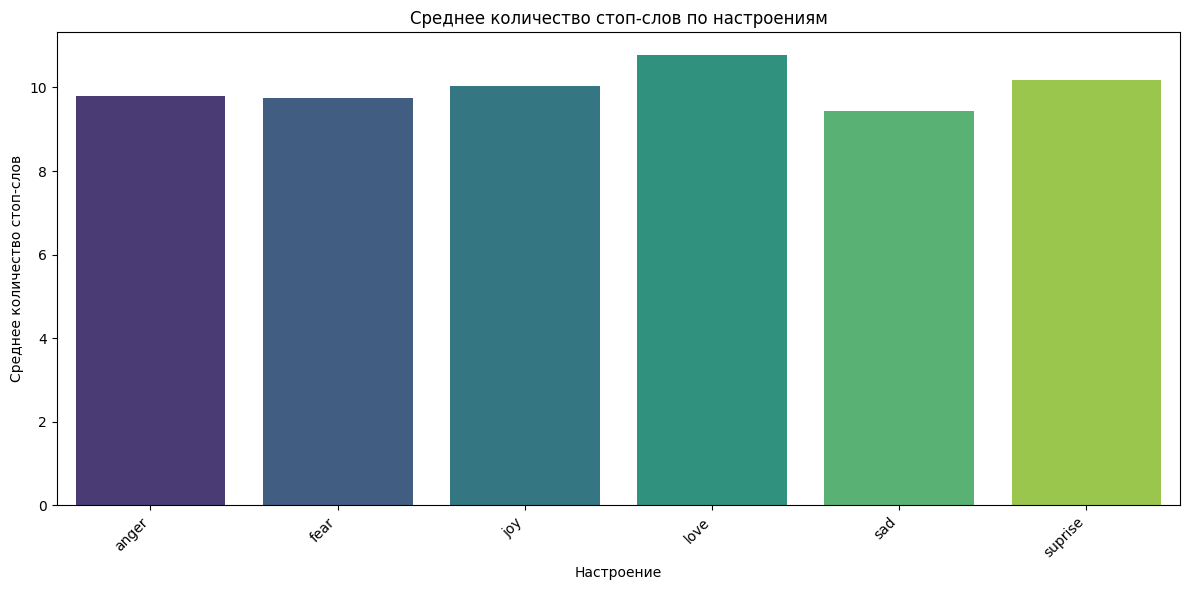

In [ ]:
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.lower().split()
    stop_words_count = sum(1 for word in words if word in stop_words)
    return stop_words_count

df_emotion['stopword_count'] = df_emotion['sentence'].apply(count_stopwords)

grouped_data = df_emotion.groupby('emotion')['stopword_count'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=grouped_data.index, y=grouped_data.values, palette="viridis")
plt.title('Среднее количество стоп-слов по настроениям')
plt.xlabel('Настроение')
plt.ylabel('Среднее количество стоп-слов')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

<ipython-input-106-03f39e54f1b9>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='stopword', y='count', data=stopwords_df, palette='viridis')


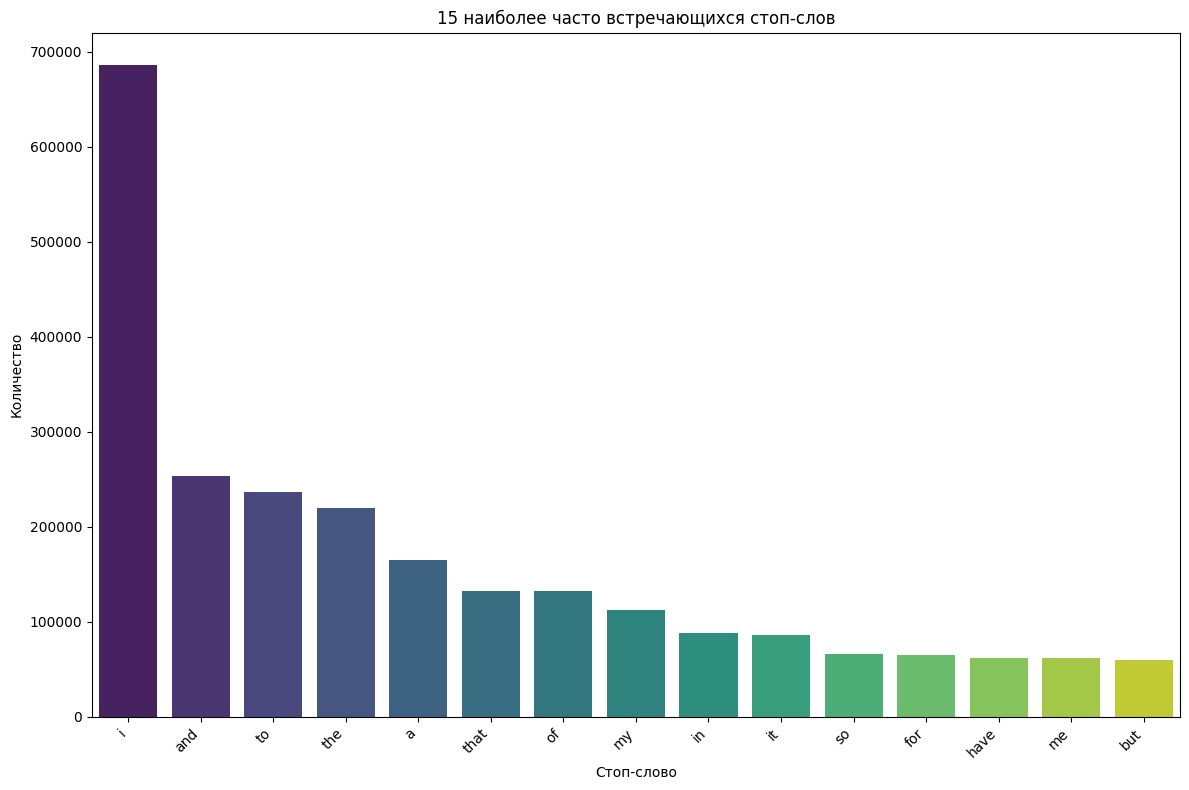

In [ ]:
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.lower().split()
    return [word for word in words if word in stop_words] # Возвращаем список стоп-слов

# Применяем функцию, чтобы получить список стоп-слов для каждого предложения
df_emotion['stopwords'] = df_emotion['sentence'].apply(count_stopwords)

# Объединяем все стоп-слова в один список
all_stopwords = []
for stopwords_list in df_emotion['stopwords']:
    all_stopwords.extend(stopwords_list)

# Считаем частоту встречаемости стоп-слов
word_counts = Counter(all_stopwords)

# Получаем 15 наиболее часто встречающихся стоп-слов
most_common_stopwords = word_counts.most_common(15)

# Создаем DataFrame для построения графика
stopwords_df = pd.DataFrame(most_common_stopwords, columns=['stopword', 'count'])

# Создаем график (столбчатая диаграмма)
plt.figure(figsize=(12, 8))  # Увеличенный размер графика
sns.barplot(x='stopword', y='count', data=stopwords_df, palette='viridis')
plt.title('15 наиболее часто встречающихся стоп-слов')
plt.xlabel('Стоп-слово')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')  # Поворачиваем подписи на оси x для лучшей читаемости
plt.tight_layout()
plt.show()

Попробуем также проанализировать bigram для всех классов

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

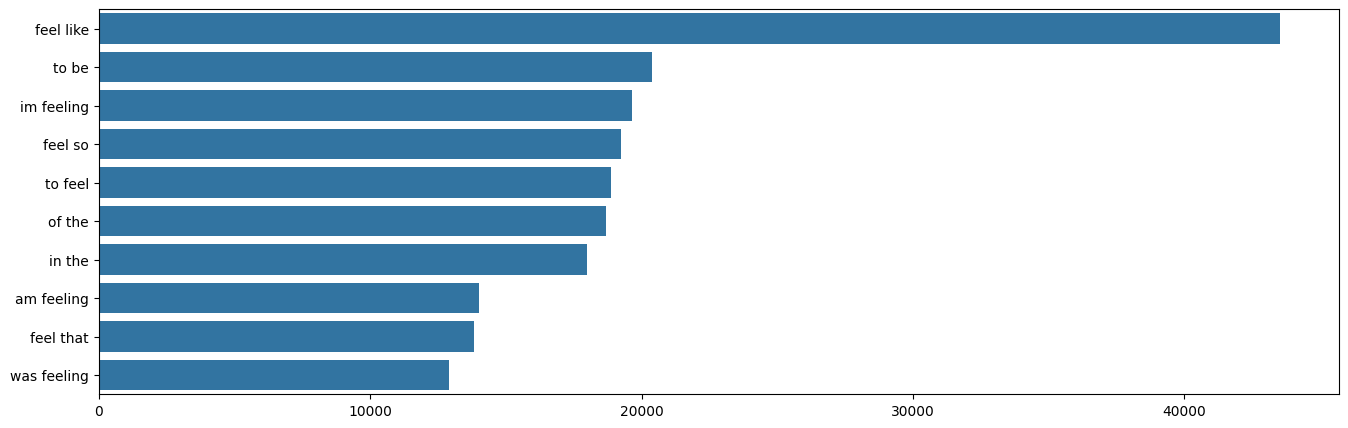

In [ ]:
plt.figure(figsize=(16,5))
top_bigrams=get_top_bigrams(df_emotion['sentence'])[:10]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x)

Как можно видеть, стоп-слова обладают огромной частотностью и засоряют данные.

**Очистка данных**

Также необходимо привести предложения к общему формату.

In [ ]:
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower().strip()
    # Удаление HTML-тегов
    text = re.sub('<[^>]+>', '', text)
    # Удаление URL
    text = re.sub(r'http\S+|www\S+|https\S+', '<URL>', text)
    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)
    # Удаление цифр
    text = re.sub(r'\d+', '', text)
    # Удаление пробелов
    text = text.strip()

    return text

In [ ]:
df_emotion['sentence'] = df_emotion['sentence'].apply(preprocess_text)

Токинизируем

In [ ]:
df_emotion['tokens'] = df_emotion['sentence'].apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Удалим стоп-слова

In [ ]:
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

In [ ]:
df_emotion['tokens'] = df_emotion['tokens'].apply(remove_stopwords)

Лемматизация/стемминг. Лематизация лучшее качество метрик показало, чем Стемминг, поэтому оставим её.

In [ ]:
lemm = WordNetLemmatizer()
df_emotion['tokens'] = df_emotion['tokens'].apply(lambda sentence: [lemm.lemmatize(word) for word in sentence])

In [ ]:
# from nltk.stem import PorterStemmer

# stemmer = PorterStemmer()
# df_emotion['tokens'] = df_emotion['tokens'].apply(lambda sentence: [stemmer.stem(word) for word in sentence])

In [ ]:
df_emotion['tokens'] = df_emotion['tokens'].apply(lambda word: ' '.join(word))

In [ ]:
X = df_emotion["tokens"]
y = df_emotion["emotion"]

Мы используем LabelEncoder чтобы преобразовать текстовые значения целевой переменной в целые числа 0, 1, 2

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Наивный Байес

## BOW

In [ ]:
nb_bow = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2,))),
    ('classifier', ComplementNB())  #подходит для данных с дисбалансом классов
])

In [ ]:
nb_bow.fit(X_train, y_train)

pred_train_nb_bow = nb_bow.predict(X_train)
pred_val_nb_bow = nb_bow.predict(X_val)

In [ ]:
print('Train:', '\n')
print(classification_report(pred_train_nb_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     46014
           1       0.92      0.93      0.92     37840
           2       0.95      0.98      0.96    109528
           3       0.93      0.84      0.88     30577
           4       0.98      0.98      0.98     96193
           5       0.89      0.83      0.86     12746

    accuracy                           0.95    332898
   macro avg       0.94      0.92      0.93    332898
weighted avg       0.95      0.95      0.95    332898

Validation: 

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     11256
           1       0.82      0.84      0.83      9420
           2       0.91      0.90      0.91     28594
           3       0.72      0.73      0.73      6666
           4       0.94      0.93      0.94     24367
           5       0.67      0.70      0.69      2922

    accuracy                           0.88     83225


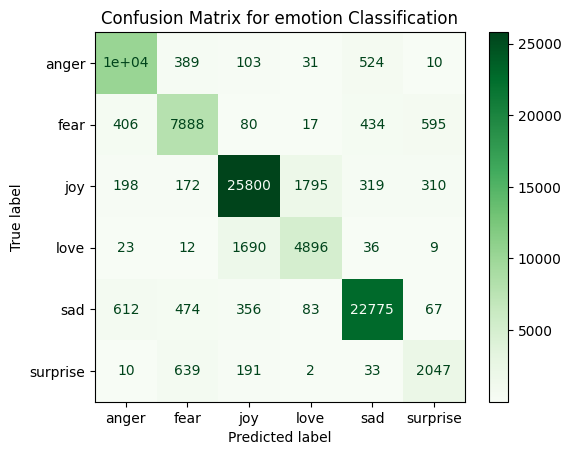

In [ ]:
cm = confusion_matrix(pred_val_nb_bow, y_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=['anger', 'fear', 'joy', 'love','sad','surprise'])
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix for emotion Classification")
plt.show()

## TF-IDF

In [ ]:
nb_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=5,
            ngram_range=(1, 2))),
    ('classifier', ComplementNB())  #подходит для данных с дисбалансом классов
])

In [ ]:
nb_tfidf.fit(X_train, y_train)


pred_train_nb_tfidf = nb_tfidf.predict(X_train)
pred_val_nb_tfidf = nb_tfidf.predict(X_val)

In [ ]:
print('Train:', '\n')
print(classification_report(pred_train_nb_tfidf, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_tfidf, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.94      0.93      0.94     46147
           1       0.90      0.91      0.90     37709
           2       0.93      0.95      0.94    110218
           3       0.89      0.81      0.85     30333
           4       0.96      0.97      0.96     95784
           5       0.86      0.80      0.83     12707

    accuracy                           0.93    332898
   macro avg       0.91      0.90      0.90    332898
weighted avg       0.93      0.93      0.93    332898

Validation: 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     11517
           1       0.86      0.86      0.86      9510
           2       0.92      0.93      0.92     27977
           3       0.82      0.77      0.79      7269
           4       0.94      0.95      0.95     23807
           5       0.76      0.73      0.75      3145

    accuracy                           0.90     83225


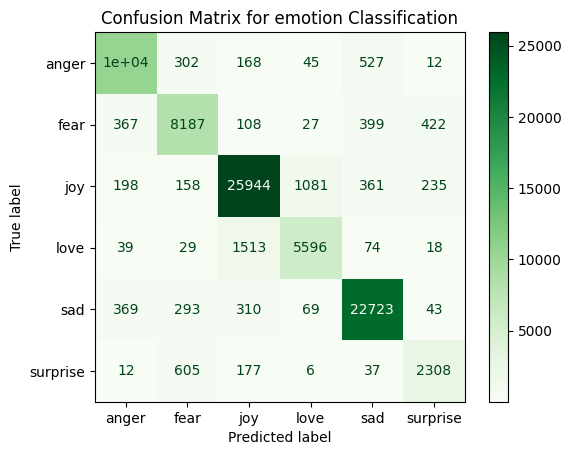

In [ ]:
cm = confusion_matrix(pred_val_nb_tfidf, y_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=['anger', 'fear', 'joy', 'love','sad','surprise'])
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix for emotion Classification")
plt.show()

# Логистическая регрессия

## BOW

In [ ]:
logr_bow = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2,))),
    ('classifier', LogisticRegression(max_iter=500, class_weight='balanced', multi_class = 'multinomial'))
])

In [ ]:
logr_bow.fit(X_train, y_train)

pred_train_logr_bow = logr_bow.predict(X_train)
pred_val_logr_bow = logr_bow.predict(X_val)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
print('Train:', '\n')
print(classification_report(pred_train_logr_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     49519
           1       0.90      0.91      0.90     39288
           2       0.90      0.99      0.94    103599
           3       0.99      0.75      0.85     36415
           4       0.94      0.99      0.96     92581
           5       1.00      0.71      0.83     16794

    accuracy                           0.93    338196
   macro avg       0.95      0.88      0.91    338196
weighted avg       0.93      0.93      0.93    338196

Validation: 

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     12305
           1       0.86      0.87      0.86      9872
           2       0.89      0.98      0.93     26226
           3       0.96      0.73      0.83      9116
           4       0.93      0.97      0.95     22941
           5       0.89      0.67      0.76      4090

    accuracy                           0.91     84550


## TF-IDF

In [ ]:
logr_tfidf = Pipeline([
    ('vectorizer',TfidfVectorizer(min_df=3,
            ngram_range=(1, 2))),
    ('classifier', LogisticRegression(max_iter=500, class_weight='balanced', multi_class = 'multinomial'))
])

In [ ]:
logr_tfidf.fit(X_train, y_train)

pred_train_logr_tfidf = logr_tfidf.predict(X_train)
pred_val_logr_tfidf= logr_tfidf.predict(X_val)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
print('Train:', '\n')
print(classification_report(pred_train_logr_tfidf, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_tfidf, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     49673
           1       0.90      0.91      0.91     39104
           2       0.90      0.99      0.94    103608
           3       0.99      0.75      0.86     36462
           4       0.94      0.99      0.96     92586
           5       1.00      0.71      0.83     16763

    accuracy                           0.93    338196
   macro avg       0.95      0.88      0.91    338196
weighted avg       0.94      0.93      0.93    338196

Validation: 

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     12333
           1       0.86      0.86      0.86      9847
           2       0.89      0.98      0.93     26241
           3       0.96      0.73      0.83      9108
           4       0.93      0.97      0.95     22943
           5       0.89      0.66      0.76      4078

    accuracy                           0.91     84550


# LDA

## BOW

In [62]:
lda_bow = Pipeline([
    ('vectorizer', TfidfVectorizer(min_df=5, ngram_range=(1, 2))),
    ('svd', TruncatedSVD(n_components=100)),
    ('classifier', LinearDiscriminantAnalysis(solver = 'lsqr'))
])

In [63]:
lda_bow.fit(X_train, y_train)

pred_train_lda_bow = lda_bow.predict(X_train)
pred_val_lda_bow = lda_bow.predict(X_val)

In [64]:
print('Train:', '\n')
print(classification_report(pred_train_lda_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_lda_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.23      0.55      0.33     19579
           1       0.19      0.49      0.27     14608
           2       0.79      0.52      0.63    170015
           3       0.17      0.45      0.25     10631
           4       0.62      0.55      0.58    107773
           5       0.36      0.41      0.38     10292

    accuracy                           0.53    332898
   macro avg       0.39      0.50      0.41    332898
weighted avg       0.64      0.53      0.56    332898

Validation: 

              precision    recall  f1-score   support

           0       0.23      0.57      0.33      4748
           1       0.19      0.47      0.27      3855
           2       0.79      0.52      0.63     42286
           3       0.17      0.46      0.25      2571
           4       0.62      0.55      0.58     27156
           5       0.34      0.40      0.37      2609

    accuracy                           0.53     83225


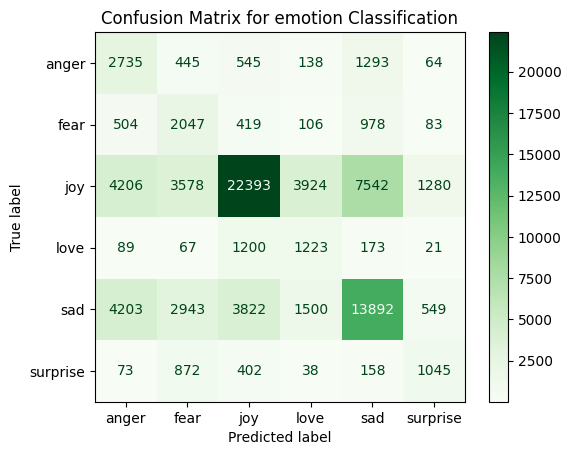

In [ ]:
cm = confusion_matrix(pred_val_lda_bow, y_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm , display_labels=['anger', 'fear', 'joy', 'love','sad','surprise'])
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix for emotion Classification")
plt.show()

# Метрики качества всех моделей

**Наивный Байес**

- **BOW**

In [ ]:
print('Train:', '\n')
print(classification_report(pred_train_nb_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     46014
           1       0.92      0.93      0.92     37840
           2       0.95      0.98      0.96    109528
           3       0.93      0.84      0.88     30577
           4       0.98      0.98      0.98     96193
           5       0.89      0.83      0.86     12746

    accuracy                           0.95    332898
   macro avg       0.94      0.92      0.93    332898
weighted avg       0.95      0.95      0.95    332898

Validation: 

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     11256
           1       0.82      0.84      0.83      9420
           2       0.91      0.90      0.91     28594
           3       0.72      0.73      0.73      6666
           4       0.94      0.93      0.94     24367
           5       0.67      0.70      0.69      2922

    accuracy                           0.88     83225


- **TF-IDF**

In [ ]:
print('Train:', '\n')
print(classification_report(pred_train_nb_tfidf, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_nb_tfidf, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.94      0.93      0.94     46147
           1       0.90      0.91      0.90     37709
           2       0.93      0.95      0.94    110218
           3       0.89      0.81      0.85     30333
           4       0.96      0.97      0.96     95784
           5       0.86      0.80      0.83     12707

    accuracy                           0.93    332898
   macro avg       0.91      0.90      0.90    332898
weighted avg       0.93      0.93      0.93    332898

Validation: 

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     11517
           1       0.86      0.86      0.86      9510
           2       0.92      0.93      0.92     27977
           3       0.82      0.77      0.79      7269
           4       0.94      0.95      0.95     23807
           5       0.76      0.73      0.75      3145

    accuracy                           0.90     83225


**Логистическая регрессия**

- **BOW**

In [ ]:
print('Train:', '\n')
print(classification_report(pred_train_logr_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     48424
           1       0.93      0.93      0.93     39574
           2       0.93      1.00      0.96    106242
           3       1.00      0.80      0.89     34608
           4       0.96      1.00      0.98     93799
           5       1.00      0.77      0.87     15549

    accuracy                           0.95    338196
   macro avg       0.97      0.91      0.93    338196
weighted avg       0.95      0.95      0.95    338196

Validation: 

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     12083
           1       0.84      0.84      0.84      9885
           2       0.90      0.93      0.92     27722
           3       0.80      0.71      0.75      7784
           4       0.94      0.96      0.95     23568
           5       0.76      0.66      0.70      3508

    accuracy                           0.89     84550


- **TF-IDF**

In [ ]:
print('Train:', '\n')
print(classification_report(pred_train_logr_tfidf, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_tfidf, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     49673
           1       0.90      0.91      0.91     39104
           2       0.90      0.99      0.94    103608
           3       0.99      0.75      0.86     36462
           4       0.94      0.99      0.96     92586
           5       1.00      0.71      0.83     16763

    accuracy                           0.93    338196
   macro avg       0.95      0.88      0.91    338196
weighted avg       0.94      0.93      0.93    338196

Validation: 

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     12333
           1       0.86      0.86      0.86      9847
           2       0.89      0.98      0.93     26241
           3       0.96      0.73      0.83      9108
           4       0.93      0.97      0.95     22943
           5       0.89      0.66      0.76      4078

    accuracy                           0.91     84550


**LDA**

In [ ]:
print('Train:', '\n')
print(classification_report(pred_train_lda_bow, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_lda_bow, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.23      0.53      0.32     20563
           1       0.20      0.50      0.29     16128
           2       0.79      0.52      0.63    172630
           3       0.18      0.45      0.25     10903
           4       0.58      0.52      0.55    107704
           5       0.35      0.41      0.38     10268

    accuracy                           0.51    338196
   macro avg       0.39      0.49      0.40    338196
weighted avg       0.63      0.51      0.55    338196

Validation: 

              precision    recall  f1-score   support

           0       0.23      0.52      0.32      5220
           1       0.21      0.49      0.29      4137
           2       0.78      0.52      0.62     42923
           3       0.18      0.44      0.25      2773
           4       0.58      0.52      0.55     26909
           5       0.34      0.40      0.37      2588

    accuracy                           0.51     84550


# Лушая модель - Логистическая регрессия (TF-IDF)

In [ ]:
print('Train:', '\n')
print(classification_report(pred_train_logr_tfidf, y_train))
print('Validation:', '\n')
print(classification_report(pred_val_logr_tfidf, y_val))

Train: 

              precision    recall  f1-score   support

           0       0.96      0.92      0.94     49673
           1       0.90      0.91      0.91     39104
           2       0.90      0.99      0.94    103608
           3       0.99      0.75      0.86     36462
           4       0.94      0.99      0.96     92586
           5       1.00      0.71      0.83     16763

    accuracy                           0.93    338196
   macro avg       0.95      0.88      0.91    338196
weighted avg       0.94      0.93      0.93    338196

Validation: 

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     12333
           1       0.86      0.86      0.86      9847
           2       0.89      0.98      0.93     26241
           3       0.96      0.73      0.83      9108
           4       0.93      0.97      0.95     22943
           5       0.89      0.66      0.76      4078

    accuracy                           0.91     84550
